# PPCA in PyStan
In part 1, we managed to reproduce $x$ with our PPCA model in PyStan, but the estimates of our parameters were not accurate. Specifically, we ended up with a latent dataset $z$ in which all points were close to zero. In part 2, we will try to approach the true values of these values more accurately.

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

## indentifying the problem

Suppose we have a model in PyStan in which the prior over $z$ is specified. Let's take a look at the outcome of our estimates.

In [13]:
prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
    
    // prior over z    
    to_vector(z) ~ normal(0.0,1.0);
}
"""
ppca_pystan_prior = pystan.StanModel(model_code=prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be3b7183348a59bc1ef8563bc7f7dd59 NOW.


We specify our parameters and generate some data.

In [14]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [15]:
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)

z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [16]:
print('real variance: ', sigma**2)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance (prior): ', sigma_p**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('simulated z (prior): ', z_p)
print()
print('real W: ', W)
print('simulated W (prior): ', W_p)
print()

real variance:  10.325146295199808
simulated variance (prior):  3.450584917006106

real z:  [[ 1.20131403  1.63820195 -2.54244078 ... -1.41070141 -0.85427849
  -0.04939393]
 [ 0.06122119  1.92939482  1.36090504 ...  1.18021201  0.57197275
   0.08219621]]
simulated z (prior):  [[ 0.01228904  0.01602958 -0.02936336 ... -0.01983507 -0.00017387
   0.00068985]
 [-0.00664064  0.00227236  0.0237601  ...  0.01884813  0.00683954
   0.00862049]]

real W:  [[-3.06918403 -1.8558038 ]
 [-2.71429525  4.29206467]
 [ 5.63559232 -2.72938964]]
simulated W (prior):  [[-467.82525153 -246.12763356]
 [  44.24340252  546.45492166]
 [ 388.03579763 -334.96000262]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [17]:
print('Model with prior: p(z) = N(z|',np.mean(z_p, axis=1),',',np.std(z_p, axis=1),')')

Model with prior: p(z) = N(z| [1.31892079e-04 1.32709091e-05] , [0.01099617 0.01076226] )


Strangely, the model with the specified prior does not produce samples of $z$ according to the given distribution: although the mean is close to zero, the std. dev. is too! This can be explained as follows. PyStan takes only 'parameters' and expected missing data is treated as a parameter as well. PyStan recieves the command to optimize all parameters according to their likelihood. The original PPCA model does not estimate $z$, it merely takes its distribution into account. PyStan, in contrast, optimizes $z$ to its prior. Since $z$ comes from a zero-centered Normal dsitribution, values of $z$ are most likely when close to zero Hence, PyStan generates $N\times M$ estimates of $z$ that are all close to zero. In turn, this is compensated by a $W$ with very large values, which is totally possible as the values of $W$ have flat priors without further restrictions. If we want PyStan to find accurate values for the other parameters, it shall be necessary to eliminate the option to optimize $z$ to its zero-mean.

In [18]:
no_prior = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan_no_prior = pystan.StanModel(model_code=no_prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_079f555cbce9fa855a4015bfa2e456f9 NOW.


In [19]:
op_no_prior = ppca_pystan_no_prior.optimizing(data=ppca_dat)

z_np = op_no_prior['z']
sigma_np = op_no_prior['sigma']
W_np = op_no_prior['W']
x_np = np.random.normal(np.matmul(W_p,z_p),sigma_np)

In [20]:
print('real variance: ', sigma**2)
print('simulated variance: (no prior)', sigma_np**2)
print()
print('real z: ', z)
print('simulated z (no prior): ', z_np)
print()
print('real W: ', W)
print('simulated W (no prior): ', W_np)
print()

real variance:  10.325146295199808
simulated variance: (no prior) 6.0412437059296

real z:  [[ 1.20131403  1.63820195 -2.54244078 ... -1.41070141 -0.85427849
  -0.04939393]
 [ 0.06122119  1.92939482  1.36090504 ...  1.18021201  0.57197275
   0.08219621]]
simulated z (no prior):  [[ -54.12861612   18.10755988  196.43846226 ...  154.62906459
    70.59487228   74.10361963]
 [ -14.04275246 -114.87322963  -29.24487566 ...  -49.38538813
   -26.17575735  -75.29104383]]

real W:  [[-3.06918403 -1.8558038 ]
 [-2.71429525  4.29206467]
 [ 5.63559232 -2.72938964]]
simulated W (no prior):  [[ 0.02310335  0.0481614 ]
 [ 0.04459733 -0.024857  ]
 [-0.09621208 -0.05821645]]



We see that the prior over $z$ causes our latent data to be very close to zero, whereas defining no prior leaves us with very large values. According to our model, $z$ is a Gaussian $\mathcal{N}(0,1)$. Let's see what latent distribution our models generate.

In [21]:
print('Model without prior: p(z) = N(z|',np.mean(z_np, axis=1),',',np.std(z_np, axis=1),')')

Model without prior: p(z) = N(z| [-0.08373916 -1.24718461] , [91.99241081 82.74953781] )


The model without a prior doesn't generate samples that are too close to the mean anymore The sampled values do not adhere to the given distribution either, but that was to be expected since we specified not prior. 
The plots below show that both models manage to reproduce $x$, but with very different latent datasets (note the scale on the axes).

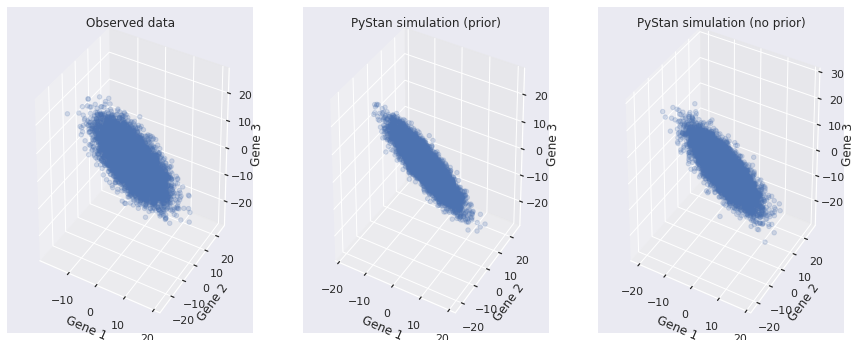

In [22]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_p[0,:],x_p[1,:],x_p[2,:], alpha=0.2)
ax.set_title('PyStan simulation (prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_np[0,:],x_np[1,:],x_np[2,:], alpha=0.2)
ax.set_title('PyStan simulation (no prior)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

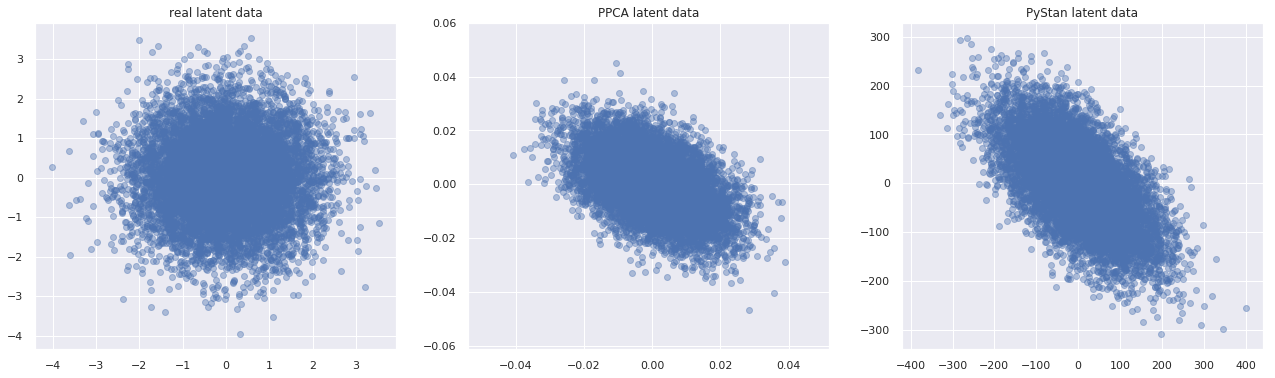

In [23]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_p[0,:], z_p[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_np[0,:], z_np[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## How does PyStan deal with this?
The [following piece of code](https://mc-stan.org/docs/2_22/stan-users-guide/missing-data.html) is taken from the [Stan Users Guide](https://mc-stan.org/docs/2_22/stan-users-guide/index.html). Let's see how PyStan deals with missing data. The following script is supposed to estimate missing values given a set of observed data, by estimating the mean and standard deviation of the observed data.

In [3]:
missingdata = '''
data {
  int<lower=0> N_obs;
  int<lower=0> N_mis;
  real y_obs[N_obs];
}
parameters {
  real mu;
  real<lower=0> sigma;
  real y_mis[N_mis];
}
model {
  y_obs ~ normal(mu, sigma);
  y_mis ~ normal(mu, sigma);
}
'''
miss = pystan.StanModel(model_code=missingdata)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a20f82b4a27dcf682c721571cfaabdf3 NOW.


In [27]:
a = np.random.normal(5,3,size=10000)
md_dat = {'N_obs': 10000, 'N_mis':1000, 'y_obs':a}
op = miss.optimizing(data=md_dat)
y = op['y_mis']

print('First missing values: ', y[:6])
print('Mean of the filled in missing data: ', np.mean(y))
print('Standard deviation of the filled in missing data: ', np.std(y))

First missing values:  [5.04089533 5.04089389 5.04089106 5.04089361 5.04089562 5.04089381]
Mean of the filled in missing data:  5.0408938906076415
Standard deviation of the filled in missing data:  2.1871436303635257e-06


As we can see, PyStan is perfectly able to estimate the mean and standard deviation of the observed data. However, when finding the values of the missing data, the scipt doesn't generate values that follow the found distribution, but attempts to return values with the highest likelihood. This is the same problem we encounter in our PPCA problem. It looks like a workaround for this problem has not yet been added to the PyStan Users guide.

## Solving the problem
### (Not solved yet!)

Our first try to work around the minimized values of $z$ is by giving the model a pre-made set $z$ to compute $\sigma$ and $W$. With those parameters then, we can try to find the actual values of $z$.

In [26]:
ppca_WS = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    matrix[M,N] z;  // latent data
}


parameters{
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan_WS = pystan.StanModel(model_code=ppca_WS)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80e580d992e22519b15a545935df3a15 NOW.


In [27]:
N=100000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)

And then we can optimize our parameters and latent dataset.

In [28]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T, 'z':np.random.normal(0,1, size=(M,N))}
op = ppca_pystan_WS.optimizing(data=ppca_dat)

sigma_sim = op['sigma']
W_sim = op['W']

print('real std. dev: ', sigma)
print('simulated std. dev.: ', sigma_sim)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real W: ', W)
print('simulated W (prior): ', W_sim)
print()

real std. dev:  1.0947377117929964
simulated std. dev.:  1.500341422390389

real W:  [[ 0.15964353 -1.04228088]
 [ 0.82424207  0.03405566]
 [ 0.20511619  1.14235664]]
simulated W (prior):  [[-0.00954498 -0.00221165]
 [-0.00358094  0.00239351]
 [ 0.00767361  0.00314351]]



In [29]:
ppca_z = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}


parameters{
    matrix[M,N] z;  // latent data
}

model{
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
    
    // prior over z    
    to_vector(z) ~ normal(0.0,1.0);
}
"""
ppca_pystan_z = pystan.StanModel(model_code=ppca_z)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47c749582d841a90ee7f2c397da51839 NOW.


In [30]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T, 'W':W_sim, 'sigma':sigma_sim}
op = ppca_pystan_z.optimizing(data=ppca_dat)

z_sim = op['z']
x_sim = np.random.normal(np.matmul(W_sim,z_sim),sigma_sim)

print('real z: ', z)
print('simulated z: ', z_sim)

real z:  [[ 0.38580134  0.43207175  0.08516408 ... -0.39646462  1.14449719
   0.5497146 ]
 [ 0.3043988   1.68553072 -0.47090915 ... -0.35641759  1.11252438
   0.58076919]]
simulated z:  [[ 1.27235652e-02  4.73298688e-04  7.45867972e-03 ... -2.43610941e-03
   1.03301355e-02  1.79123473e-03]
 [ 2.60964809e-03 -5.49215977e-04  1.96057875e-03 ...  4.47250076e-05
   3.61090412e-03  1.64331982e-03]]


In [31]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]
x_ppca = np.matmul(W_ppca,z_ppca)
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance: ', sigma_sim**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()
print('real WW^T: ', np.matmul(W,W.T))
print('PPCA WW^T: ', np.matmul(W_ppca,W_ppca.T))
# print('PPCA W (em): ', W_ppca_em)
print('simulated WW^T: ', np.matmul(W_sim, W_sim.T))
print()

real variance:  1.1984506576217657
PPCA variance:  1.1952873496239593
simulated variance:  2.2510243837404156

real z:  [[ 0.38580134  0.43207175  0.08516408 ... -0.39646462  1.14449719
   0.5497146 ]
 [ 0.3043988   1.68553072 -0.47090915 ... -0.35641759  1.11252438
   0.58076919]]
PPCA z:  [[ 1.22958723  0.1720141   0.61938102 ... -0.41005832  0.6519498
  -0.05117879]
 [ 0.37691963  0.58880245  0.19520247 ...  0.85823236  0.1142727
  -1.59999418]]
simulated z:  [[ 1.27235652e-02  4.73298688e-04  7.45867972e-03 ... -2.43610941e-03
   1.03301355e-02  1.79123473e-03]
 [ 2.60964809e-03 -5.49215977e-04  1.96057875e-03 ...  4.47250076e-05
   3.61090412e-03  1.64331982e-03]]

real W:  [[ 0.15964353 -1.04228088]
 [ 0.82424207  0.03405566]
 [ 0.20511619  1.14235664]]
PPCA W:  [[-1.03994479  0.64232726]
 [-1.0896695  -0.5643854 ]
 [ 0.38492643  0.13766613]]
simulated W:  [[-0.00954498 -0.00221165]
 [-0.00358094  0.00239351]
 [ 0.00767361  0.00314351]]

real WW^T:  [[ 1.11183548  0.09608935 -1.1

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


As we can see, this method is actually less reliable than the original, so this is not our answer.

In [32]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}
op_prior = ppca_pystan_prior.optimizing(data=ppca_dat)
z_p = op_prior['z']
sigma_p = op_prior['sigma']
W_p = op_prior['W']
x_p = np.random.normal(np.matmul(W_p,z_p),sigma_p)

In [33]:
print(sigma_p)
print(W_p)

0.6312243197294491
[[ 401.21716221  150.73004553]
 [ 238.35281673 -373.74412432]
 [-325.30361133 -328.86919254]]
